(dl/05-training)=
# Activations and Gradients

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/ok-transformer/blob/master/docs/nb/dl/05-training.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/ok-transformer?style=social)](https://github.com/particle1331/ok-transformer)

---

**Readings:**  {cite}`layernorm` {cite}`batchnorm`

## Introduction

Neural network training involves computation across millions (or [billions](https://en.wikipedia.org/wiki/Large_language_model)) of weights and activations. This process is [known to be fragile](https://lossfunctions.tumblr.com/). In this notebook, we attach hooks to deep neural nets to analyze the statistics of activations, weights and gradients, and consider pitfalls when they are improperly scaled. Finally, we introduce **layer normalization** (LN) {cite}`layernorm` which make training deep networks so much easier. 

In particular, we find that using normalization layers prevent rank collapse of activations and controls the magnitude of gradients. This was shown for networks with increasing depth and trained with increasing learning rates. We also consider the effects of the choice of **activation function**. We find that activations such as GELU {cite}`gelu` and Mish {cite}`mish` have unique effects that are similar to LN on unnormalized networks.

## Preliminaries

In [1]:
import math
import torch
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib_inline import backend_inline

DATASET_DIR = Path("./data").absolute()
RANDOM_SEED = 1
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats("svg")

Still using the names dataset from the [previous notebook](dl/04-lm):

In [2]:
import os
if not os.path.isfile("./data/surnames_freq_ge_100.csv"):
    !wget -O ./data/surnames_freq_ge_100.csv https://raw.githubusercontent.com/particle1331/spanish-names-surnames/master/surnames_freq_ge_100.csv
    !wget -O ./data/surnames_freq_ge_20_le_99.csv https://raw.githubusercontent.com/particle1331/spanish-names-surnames/master/surnames_freq_ge_20_le_99.csv
else:
    print("Data files already exist.")

col = ["surname", "frequency_first", "frequency_second", "frequency_both"]
df1 = pd.read_csv(DATASET_DIR / "surnames_freq_ge_100.csv", names=col, header=0)
df2 = pd.read_csv(DATASET_DIR / "surnames_freq_ge_20_le_99.csv", names=col, header=0)

Data files already exist.


In [3]:
FRAC_LIMIT = 0.30
df = pd.concat([df1, df2], axis=0)[['surname']].sample(frac=FRAC_LIMIT)
df['surname'] = df['surname'].map(lambda s: s.lower())
df['surname'] = df['surname'].map(lambda s: s.replace("de la", "dela"))
df['surname'] = df['surname'].map(lambda s: s.replace(" ", "_"))

names = [n for n in df.surname.tolist() if "'" not in n and 'ç' not in n and len(n) >= 2]
df = df[['surname']].dropna().astype(str)
df = df[df.surname.isin(names)]
df.to_csv(DATASET_DIR / 'spanish_surnames.csv', index=False)
df = pd.read_csv(DATASET_DIR / 'spanish_surnames.csv').dropna()
df.head()

surname
0   agredano
1   poblador
2      girba
3  rabanales
4      yucra

### Datasets

Defining here the dataset class used in the [previous notebook](dl/04-lm):

In [4]:
import torch
from torch.utils.data import Dataset

class CharDataset(Dataset):
    def __init__(self, contexts: list[str], targets: list[str], chars: str):
        self.chars = chars
        self.ys = targets
        self.xs = contexts
        self.block_size = len(contexts[0])
        self.itos = {i: c for i, c in enumerate(self.chars)}
        self.stoi = {c: i for i, c in self.itos.items()}

    def get_vocab_size(self):
        return len(self.chars)
    
    def __len__(self):
        return len(self.xs)
    
    def __getitem__(self, idx):
        x = self.encode(self.xs[idx])
        y = torch.tensor(self.stoi[self.ys[idx]]).long()
        return x, y 
        
    def decode(self, x: torch.tensor) -> str:
        return "".join([self.itos[c.item()] for c in x])

    def encode(self, word: str) -> torch.tensor:
        return torch.tensor([self.stoi[c] for c in word]).long()


def build_dataset(names, block_size=3):
    """Build word context -> next char target lists from names."""
    xs = []     # context list
    ys = []     # target list
    for name in names:
        context = ["."] * block_size
        for c in name + ".":
            xs.append(context)
            ys.append(c)
            context = context[1:] + [c]
    
    chars = sorted(list(set("".join(ys))))
    return CharDataset(contexts=xs, targets=ys, chars=chars)

Example dataset with block size 3:

In [5]:
dataset = build_dataset(names, block_size=3)
xs = []
ys = []
for i in range(7):
    x, y = dataset[i]
    xs.append(x)
    ys.append(y)

pd.DataFrame({'x': [x.tolist() for x in xs], 'y': [y.item() for y in ys], 'x_word': ["".join(dataset.decode(x)) for x in xs], 'y_char': [dataset.itos[c.item()] for c in ys]})

x   y x_word y_char
0   [0, 0, 0]   2    ...      a
1   [0, 0, 2]   8    ..a      g
2   [0, 2, 8]  19    .ag      r
3  [2, 8, 19]   6    agr      e
4  [8, 19, 6]   5    gre      d
5  [19, 6, 5]   2    red      a
6   [6, 5, 2]  15    eda      n

Ideally, we should use a stratified *k*-fold that ensures character distribution is the same between slips. But too lazy. Here we just partition the names dataset by index to create the validation and train datasets.

In [6]:
SPLIT_RATIO = 0.30
split_point = int(SPLIT_RATIO * len(names))
names_train = names[:split_point]
names_valid = names[split_point:]
train_dataset = build_dataset(names_train, block_size=3)
valid_dataset = build_dataset(names_valid, block_size=3)

len(train_dataset), len(valid_dataset)

(55773, 130617)

## Weight initialization

SGD requires choosing an arbitrary starting point $\boldsymbol{\Theta}_{\text{init}}.$ Setting all weights to zero or some constant does not work as symmetry in the neurons of the network will make it difficult (if not impossible) to train the model. Hence, setting the weights randomly to break symmetry is a good starting point. However, this is still not enough since the variance of every neuron is [additive](https://www.deeplearning.ai/ai-notes/initialization/index.html#IV)  (again due to symmetry and some assumptions):

$${\sigma_{\boldsymbol{\mathsf{y}}}} = \sqrt{n} \cdot {\sigma_{\boldsymbol{\mathsf{w}}}} \, {\sigma_{\boldsymbol{\mathsf{x}}}}$$

where $n = |\boldsymbol{\mathsf{x}}|.$

In [7]:
import seaborn as sns

x = torch.randn(1000, 100)
w = torch.randn( 100, 200)
y = x @ w

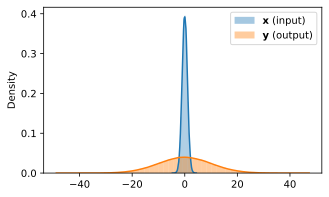

In [8]:
plt.figure(figsize=(5, 3))
sns.distplot(x.reshape(-1), color="C0", label='$\mathbf{x}$ (input)');
sns.distplot(y.reshape(-1), color="C1", label='$\mathbf{y}$ (output)');
plt.legend();

Observe that the output $\boldsymbol{\mathsf{y}} = \boldsymbol{\mathsf{x}}^\top \boldsymbol{\mathsf{w}}$ for normally distributed $\boldsymbol{\mathsf{x}}$ and $\boldsymbol{\mathsf{w}}$ starts to spread out. This makes sense since we are adding $n$ terms where where $n = |\boldsymbol{\mathsf{x}}|.$ Ideally, we want $\boldsymbol{\mathsf{y}}$ to have the same standard deviation to maintain stable activation flow. Otherwise, activations will recursively grow at each layer. This becomes increasingly problematic with depth.

<br>

**Dead neurons.** Activations have regions where their gradients **saturate**, so it is very important to control the range of preactivations. A **dead neuron** has gradients that is mostly zero over the training examples. A neuron can be dead at initialization, or during training. 

For instance, a high learning rate can result in large weights that saturate the neurons similar to the situation above. For dense layers, dead neurons tend to remain dead for a long time since weight gradients are too small to significantly change the existing weights for that neuron.

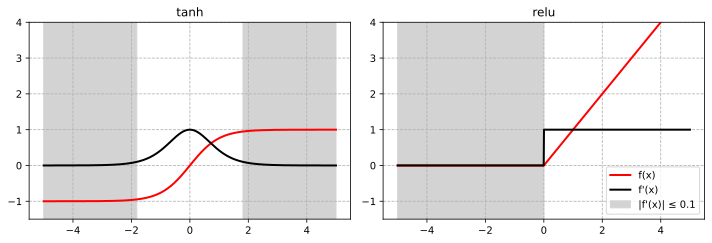

In [9]:
activations = {
    "tanh": torch.tanh,
    "relu": torch.relu,
}

def d(f, x):
    """Compute derivative of activation with respect to x."""
    y = f(x)
    y.backward(torch.ones_like(x))
    return x.grad

def plot_activation(act: str, ax, x):
    x.grad = None
    f = activations[act]
    y = f(x)
    df = d(f, x)
    x, y = x.detach().numpy(), y.detach().numpy()
    
    # Plotting
    ax.plot(x, y,  linewidth=2, color='red',   label="f(x)")
    ax.plot(x, df, linewidth=2, color='black', label="f'(x)")
    ax.set_title(act)
    ax.grid(linestyle="dashed")
    ax.set_ylim(-1.5, 4)
    if act == "tanh":
        ax.axvspan(-5, -1.8183, -10, 10, color='lightgray')
        ax.axvspan(1.8183, 5,   -10, 10, color='lightgray')
    elif act == "relu":
        ax.axvspan(-5, 0, -10, 10, color='lightgray', label="|f'(x)| ≤ 0.1")
        ax.legend(loc='lower right')
    

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))

x = torch.linspace(-5, 5, 1000, requires_grad=True)
for i, act_name in enumerate(activations.keys()):
    plot_activation(act_name, ax[i], x)  # divmod(m, n) = m // n, m % n

fig.tight_layout()

**Figure.** Plotting activations and activation gradients. Saturation regions where derivatives are small (here set to `0.1`) are highlighted gray.

<br>

**Xavier init.** {cite}`xavier` Since the $\sigma_{\boldsymbol{\mathsf{y}}} = \sqrt{n} \cdot \sigma_{\boldsymbol{\mathsf{w}}} \, \sigma_{\boldsymbol{\mathsf{x}}}$, one straightforward fix is to initialize the weights $\boldsymbol{\mathsf{w}}$ with a distribution having ${\sigma_{\boldsymbol{\mathsf{w}}}}=\frac{1}{\sqrt{n}}$ where $n = |\boldsymbol{\mathsf{x}}|.$ Moreover, we set biases to zero. Note that setting the standard deviation turns out to be equivalent to just scaling the random variable with $\frac{1}{\sqrt{n}}$ by linearity of expectation:

In [10]:
x = torch.randn(1000, 100)
w = torch.randn( 100, 200)  # Xavier normal. For xavier uniform, set w ~ U[-a, a] with a = (3 / n) ** 0.5
y = x @ (w / np.sqrt(100))

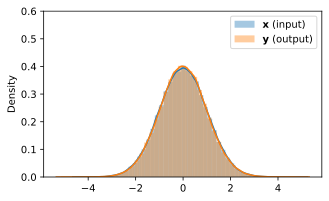

In [11]:
plt.figure(figsize=(5, 3))
sns.distplot(x.reshape(-1), color="C0", label='$\mathbf{x}$ (input)')
sns.distplot(y.reshape(-1), color="C1", label='$\mathbf{y}$ (output)')
plt.ylim(0, 0.6)
plt.legend();

**Remark.** Proper weight init can also help with the variance of gradients. For dense layers, the backprop equations that relate input and output gradients are linear with $\boldsymbol{\mathsf{w}}^\top,$ so that we can alternatively sample weights with $\sigma = \frac{1} {\sqrt{n_\text{out}}}.$ Indeed, weight init can be implemented with the [fan-in / fan-out average](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.xavier_normal_) $\sqrt{\frac{2}{{n_\text{in} + n_\text{out}}}}.$

<br>

**Gain.** Note that this scale factor only holds for linear layers. Nonlinear activations squashes its input which compounds as we stack layers in deep networks. The factor $\mathsf{g}$ such that ${\sigma_{\boldsymbol{\mathsf{y}}}} = \mathsf{g} \cdot {\sigma_{\boldsymbol{\mathsf{x}}}}$ in called [gain](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain). This can be introduced as a factor on the standard deviation of the weights, i.e. setting the parameters of the distribution such that $\sigma_{\boldsymbol{\mathsf{w}}} = \mathsf{g} \frac{1}{\sqrt{n}}$ where $n = |\boldsymbol{\mathsf{x}}|$ for some $\mathsf{g} > 0.$ 
Typically, weights are sampled from either normal or uniform distributions.

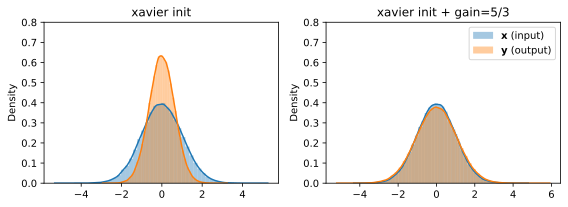

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

n = 100
x = torch.randn(1000, n)
z = torch.tanh(x)   # Note: input of a hidden layer is an activation
w = torch.randn(n, 200) / n ** 0.5
y = z @ w

sns.distplot(x.reshape(-1), ax=ax[0], color="C0", label='$\mathbf{x}$ (input)');
sns.distplot(y.reshape(-1), ax=ax[0], color="C1", label='$\mathbf{y}$ (output)');
ax[0].set_title("xavier init", size=12)
ax[0].set_ylim(0, 0.8)

g = 5 / 3   # tanh gain
x = torch.randn(1000, n)
z = torch.tanh(x)
w = torch.randn(n, 200) * g / n ** 0.5
y = z @ w

sns.distplot(x.reshape(-1), ax=ax[1], color="C0", label='$\mathbf{x}$ (input)');
sns.distplot(y.reshape(-1), ax=ax[1], color="C1", label='$\mathbf{y}$ (output)');

ax[1].set_title("xavier init + gain=5/3", size=12)
ax[1].set_ylim(0, 0.8)
ax[1].legend()
fig.tight_layout();

**Kaiming init.** Note that $\mathsf{g}$ for an activation is usually obtained using some heuristic or by performing [empirical tests](https://github.com/pytorch/pytorch/issues/24991), e.g. {cite}`kaiming` sets $\mathsf{g} = \sqrt{2}$ since half of ReLU outputs are zero in the calculation of variance (see [proof](https://courses.cs.washington.edu/courses/cse543/23au/schedule/Kaiming_init.pdf)). See also [`calculate_gain`](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain) for other commonly used activations. 

PyTorch default for `nn.Linear` is [essentially](https://github.com/pytorch/pytorch/issues/57109#issuecomment-1310430244) $\mathsf{g} = \frac{1}{\sqrt{3}}$ with Xavier uniform fan-in initialization. Note that the standard deviation of the uniform distribution $U[-a, a]$ is specified by the bound $a$, i.e. $\sigma = \frac{a}{\sqrt{3}}.$ The Pytorch implementation sets $a = \frac{1}{\sqrt{n}}$ getting an effective gain of $\frac{1}{\sqrt{3}}.$ 

In [13]:
import torch.nn as nn

fan_in = 100
lin = nn.Linear(fan_in, 1234)
w = lin.weight.data
w.std(), 1 / (np.sqrt(3) * np.sqrt(fan_in))

(tensor(0.0576), 0.05773502691896258)

**Remark.** The formula for $\sigma$ of $U[-a, a]$ also explains the form of [`nn.init.kaiming_uniform_`](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_).

In [14]:
del lin

<br>

**Logits.** Note that the Xavier init heuristic also applies to the weights of the logits layer. It essentially acts as softmax temperature:

In [15]:
import torch.nn.functional as F

x = torch.randn(1, 100)
w = torch.randn(100, 10)
y0 = F.softmax(x @ w)
y1 = F.softmax(x @ (w / np.sqrt(100)))

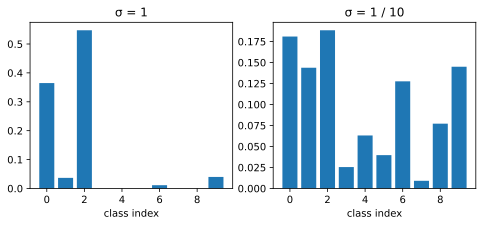

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].set_title("σ = 1")
ax[1].set_title("σ = 1 / 10")
ax[0].set_xlabel("class index")
ax[1].set_xlabel("class index")
ax[0].bar(range(10), y0[0])
ax[1].bar(range(10), y1[0]);

## Training with hooks

The following [previously introduced](dl/03-cnn) class is used to make model training easier. Note that the class is augmented with  **hooks** which we will use to obtain activation and gradient statistics during forward and backward passes. The hooks are attached to the model before training, then removed after.

In [17]:
from tqdm.notebook import tqdm
from contextlib import contextmanager
from torch.utils.data import DataLoader
import torch.nn as nn

DEVICE = "mps"


@contextmanager
def eval_context(model):
    """Temporarily set to eval mode inside context."""
    state = model.training
    model.eval()
    try:
        yield
    finally:
        model.train(state)


class InfiniteDataLoader:
    def __init__(self, data_loader):
        self.data_loader = data_loader
        self.data_iterator = iter(self.data_loader)

    def __iter__(self):
        return self

    def __next__(self):
        try:
            batch = next(self.data_iterator)
        except StopIteration:
            self.data_iterator = iter(self.data_loader)
            batch = next(self.data_iterator)
        return batch


class Trainer:
    def __init__(self,
                 model, optim, loss_fn, 
                 scheduler=None,
                 callbacks=[],
                 device=DEVICE, verbose=True):
        
        self.model = model
        self.optim = optim
        self.device = device
        self.loss_fn = loss_fn
        self.logs = {"train": {"loss": []}}
        self.verbose = verbose
        self.scheduler = scheduler
        self.callbacks = callbacks
        self.forward_hooks = []
        self.backward_hooks = []
    
    def __call__(self, x):
        return self.model(x.to(self.device))

    def forward(self, batch):
        x, y = batch
        x = x.to(self.device)
        y = y.to(self.device)
        return self.model(x), y

    def train_step(self, batch):
        preds, y = self.forward(batch)
        loss = self.loss_fn(preds, y)
        loss.backward()
        self.optim.step()
        self.optim.zero_grad()
        return loss

    @torch.inference_mode()
    def valid_step(self, batch):
        preds, y = self.forward(batch)
        loss = self.loss_fn(preds, y, reduction="sum")
        return loss

    def register_hooks(self,    # !!!
        forward_hooks=[], backward_hooks=[], 
        layer_types: tuple = (nn.Linear, nn.Conv2d)
    ):
        for _, module in self.model.named_modules():
            if isinstance(module, layer_types):
                for f in forward_hooks:
                    h = module.register_forward_hook(f)
                    self.forward_hooks.append(h)
                
                for g in backward_hooks:
                    h = module.register_backward_hook(g)
                    self.backward_hooks.append(h)

    def remove_hooks(self):
        for h in self.forward_hooks + self.backward_hooks:
            h.remove()
    
    def run(self, steps, train_loader):
        train_loader = InfiniteDataLoader(train_loader)
        for _ in tqdm(range(steps)):
            # optim and lr step
            batch = next(train_loader)
            loss = self.train_step(batch)
            if self.scheduler:
                self.scheduler.step()

            # step callbacks
            for callback in self.callbacks:
                callback()

            # logs @ train step
            self.logs["train"]["loss"].append(loss.item())

    def evaluate(self, data_loader):
        with eval_context(self.model):
            valid_loss = 0.0
            for batch in data_loader:
                loss = self.valid_step(batch)
                valid_loss += loss.item()

        return {"loss": valid_loss / len(data_loader.dataset)}

**Remark.** Note that we take in total steps per run instead of epochs. 
We define an infinite data loader in case the number of steps exceed one epoch.
We also skip validation during training since we are only currently concerned with training dynamics (not generalization). 

Forward hooks are expected to look like:

```python
hook(module, input, output) -> None or modified output
```

On the other hand, backward hook functions should look like: 

```python
hook(module, grad_in, grad_out) -> None or modified grad_in
```

<br>

Next we define classes for handling outputs of the hooks:

In [18]:
class HookHandler:
    def __init__(self):
        self.records = {}

    def hook_fn(self, module, input, output):
        raise NotImplementedError


class OutputStats(HookHandler):
    def hook_fn(self, module, input, output):
        self.records[module] = self.records.get(module, [])
        self.records[module].append(output)


class WeightGradientStats(HookHandler):
    def hook_fn(self, module, grad_in, grad_out):
        self.records[module] = self.records.get(module, [])
        for t in grad_in:
            if t is not None and t.shape == module.weight.data.shape:
                self.records[module].append(t)


class ActivationGradientStats(HookHandler):
    def hook_fn(self, module, grad_in, grad_out):
        self.records[module] = self.records.get(module, [])
        for t in grad_in:
            if t is not None:
                self.records[module].append(grad_in[0])


class DyingReluStats(HookHandler):
    def __init__(self, sat_threshold=1e-8, frac_threshold=0.95):
        super().__init__()
        self.sat_threshold = sat_threshold
        self.frac_threshold = frac_threshold

    def hook_fn(self, module, input, output):
        self.records[module] = self.records.get(module, [])
        B = output.shape[0]
        count_dead = ((output < self.sat_threshold).float().sum(dim=0) / B) > self.frac_threshold
        frac_dead = count_dead.float().mean()
        self.records[module].append(frac_dead.item())

Setting up our experiment harness:

In [19]:
def get_model(vocab_size: int,
              block_size: int,
              emb_size: int,
              width: int,
              num_linear: int):

    layers = [
        nn.Embedding(vocab_size, emb_size), nn.Flatten(),
        nn.Linear(block_size * emb_size, width), nn.ReLU()
    ] 
    
    for _ in range(num_linear):
        layers.append(nn.Linear(width, width))
        layers.append(nn.ReLU())

    layers.append(nn.Linear(width, vocab_size))
    model = nn.Sequential(*layers)
    return model
    

def init_model(model, init_fn):
    """Expected `init_fn` modifies linear layer weights in-place. See 
    https://pytorch.org/docs/stable/nn.init.html for init functions."""
    for m in model.modules():
        if isinstance(m, nn.Linear):
            init_fn(m.weight)
    return model


def run(model,
        train_dataset: Dataset,
        batch_size: int,
        hooks: list[dict], 
        steps: int, 
        lr: float) -> Trainer:

    # Setup optimization and data loader
    loss_fn = F.cross_entropy
    model = model.to(DEVICE)
    optim = torch.optim.SGD(model.parameters(), lr=lr)
    trainer = Trainer(model, optim, loss_fn, device=DEVICE)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)

    # Finally, training...
    try:
        for hook_dict in hooks:
            trainer.register_hooks(
                forward_hooks=[h.hook_fn for h in hook_dict["forward_hooks"]], 
                backward_hooks=[h.hook_fn for h in hook_dict["backward_hooks"]], 
                layer_types=hook_dict["layer_types"]
            )

        trainer.run(steps=steps, train_loader=train_loader)

    except Exception as e:
        print(e)
    finally:
        trainer.remove_hooks()

    return trainer

<br>

The task and model used here is from the previous notebook. In the `init_model` function, we iterate over the layers and apply a function from the [`torch.nn.init`](https://pytorch.org/docs/stable/nn.init.html) library to modify layer weights in-place. The [`xavier_uniform_`](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.xavier_uniform_) implementation uses fan average mode. We also use a gain of $\sqrt{2}$ for the ReLU activation.

In [20]:
def init_hooks() -> list[dict]:
    global linear_outs_stats
    global linear_grad_stats
    global dead_relu_stats
    global relu_outs_stats
    global relu_grad_stats

    linear_outs_stats = OutputStats()
    linear_grad_stats = WeightGradientStats()
    dead_relu_stats = DyingReluStats(sat_threshold=1e-8, frac_threshold=0.95)
    relu_outs_stats = OutputStats()
    relu_grad_stats = ActivationGradientStats()

    return [
        {"forward_hooks": [linear_outs_stats], "backward_hooks": [linear_grad_stats], "layer_types": (nn.Linear,)},
        {"forward_hooks": [dead_relu_stats, relu_outs_stats], "backward_hooks": [relu_grad_stats], "layer_types": (nn.ReLU,)}
    ]
    

model_params = {
    "vocab_size": 29,
    "block_size": 3,
    "emb_size": 10,
    "width": 30,
    "num_linear": 2
}

train_params = {
    "steps": 1000,
    "batch_size": 32,
    "lr": 0.1
}

init_fn = lambda w: torch.nn.init.xavier_uniform_(w, gain=np.sqrt(2))
model = init_model(get_model(**model_params), init_fn)
hooks = init_hooks()
trainer = run(model, train_dataset, **train_params, hooks=hooks)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [21]:
def plot_training_loss(trainer, window=0.05, figsize=(5, 3)):
    moving_avg = []
    train_loss = trainer.logs["train"]["loss"]
    steps = len(train_loss)
    w = int(window * steps)   # window size
    for s in range(steps):
        moving_avg.append(np.mean(train_loss[-w + s + 1: s + 1]))

    plt.figure(figsize=figsize)
    plt.plot(trainer.logs["train"]["loss"], alpha=0.7, label="train")
    plt.plot(moving_avg, color="C0", label="train (MA)")
    plt.ylabel("loss")
    plt.xlabel("steps")
    plt.ylim(min(trainer.logs["train"]["loss"]) - 0.2, min(max(trainer.logs["train"]["loss"]) + 0.2, 5.0))
    plt.grid(linestyle="dashed", alpha=0.6)
    plt.legend();

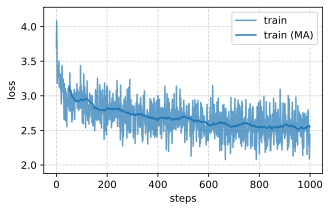

In [22]:
plot_training_loss(trainer)

### Histograms

The hooks stored activation and gradient statistics during training which we now visualize:

```{margin}
[Colorful dimension](https://forums.fast.ai/t/the-colorful-dimension/42908/5)
```

In [23]:
def plot_training_histograms(stats: list[HookHandler], 
                             bins: int = 100, 
                             num_stds: int = 4, 
                             cmaps: list[str] = None, 
                             labels: list[str] = None,
                             figsize=(6, 2), 
                             aspect: int = 5):
    
    rows = len(stats)
    cols = len(stats[0].records.keys())
    cmaps = ["viridis"] * rows if cmaps is None else cmaps
    H, W = figsize
    fig, ax = plt.subplots(rows, cols, figsize=(H * rows, W * cols))

    # calculate range per row (i.e. per handler)
    # same range => show vanishing / exploding over layers
    h = {}
    for i in range(rows):
        acts = []
        for j, m in enumerate(stats[0].records.keys()):
            if m not in stats[i].records:
                continue
            acts.append(torch.stack([t.reshape(-1) for t in stats[i].records[m]], dim=0).cpu().reshape(-1))
        h[i] = torch.concat(acts).std().item() * num_stds

    # calculate histograms
    for i in range(rows):
        for j, m in enumerate(stats[0].records.keys()):    
            if m not in stats[i].records:
                continue

            acts = torch.stack([t.reshape(-1) for t in stats[i].records[m]], dim=0).cpu()
            with torch.no_grad():
                # Add one count -> log = more colorful, note: log 1 = 0.
                # total count (i.e. sum per col) == batch_size * num_neurons, .: normalized
                hists = [(torch.histc(acts[j], bins=bins, min=-h[i], max=h[i]) + 1).log().cpu().numpy().reshape(1, -1) for j in range(acts.shape[0])]

            # histogram image
            axf = lambda i, j: ax[j] if rows == 1 else ax[i, j]
            axf(i, j).set_title(m.__class__.__name__ + "." + str(j), size=10)
            axf(i, j).imshow(np.flip(np.concatenate(hists, axis=0).T, axis=0), aspect='auto', cmap=cmaps[i])     # (!)
            axf(i, j).set_aspect(aspect)                                                                 # transpose => positive vals = down 
            axf(i, j).set_yticks([])                                                                     # flip => positive vals = up
            if j == 0 and labels is not None:
                axf(i, j).set_ylabel(f"{labels[i]}\n[-{h[i]:.1e}, {h[i]:.1e}]")
            else:                                                           
                axf(i, j).set_ylabel(f"[-{h[i]:.1e}, {h[i]:.1e}]")
            axf(i, j).set_xlabel("steps")
    
    fig.tight_layout()
    plt.show()

In [24]:
def plot_training_stats(stats: list[HookHandler], 
                        labels: list[str] = None, 
                        colors: list[str] = None, 
                        figsize=(6, 2), 
                        plot_neg_std=True):
    
    rows = len(stats)
    cols = len(stats[0].records.keys())
    colors = [f"C{i}" for i in range(rows)] if colors is None else colors
    H, W = figsize
    fig, ax = plt.subplots(rows, cols, figsize=(H * rows, W * cols))

    # calculate mean and std
    axf = lambda i, j: ax[j] if rows == 1 else ax[i, j]
    hs = {}  # range estimate of stdv over all layers
    hu = {}  # range estimate of mean over all layers
    for i in range(rows):
        hss = []  # range estimate of stdv over each layer 
        hus = []  # range estimate of mean over each layer 
        for j, m in enumerate(stats[0].records.keys()):    
            if m not in stats[i].records:
                continue

            with torch.no_grad():
                ss_a = []
                ss_b = []
                us = []
                for t in stats[i].records[m]:
                    s = t.std().item()
                    u = t.mean().item()
                    ss_a.append(u - s)
                    ss_b.append(u + s)
                    us.append(u)
            
            hss.append(max(np.abs(np.array(ss_a)).mean(), np.abs(np.array(ss_b)).mean()))
            hus.append(np.array(us).mean())

            # plot
            axf(i, j).set_title(m.__class__.__name__ + "." + str(j), size=10)
            axf(i, j).plot(ss_b, color=colors[i], label=f"$\mu \pm \sigma$")
            if plot_neg_std:
                axf(i, j).plot(ss_a, color=colors[i])
            axf(i, j).plot(us, color="black", label=f"$\mu$", alpha=0.8)
            axf(i, j).set_xlabel("steps")
            axf(i, j).grid(linestyle="dashed", alpha=0.6)
            if j == cols - 1:
                axf(i, j).legend()
            if j == 0 and labels is not None:
                axf(i, j).set_ylabel(labels[i])

        hs[i] = np.abs(np.array(hss)).mean()
        hu[i] = np.array(hus).mean()

    # set y-lims
    for i in range(rows):
        for j, m in enumerate(stats[0].records.keys()):    
            if m not in stats[i].records:
                continue
            
            if plot_neg_std:
                h = max(abs(hu[i] - 2 * hs[i]), abs(hu[i] + 2 * hs[i]))
                axf(i, j).set_ylim(-h, h)
            else:
                axf(i, j).set_ylim(hu[i] - 1 * hs[i], hu[i] + 2 * hs[i])
                
    fig.tight_layout()
    plt.show()

loss (last 100 steps): 2.536505391597748


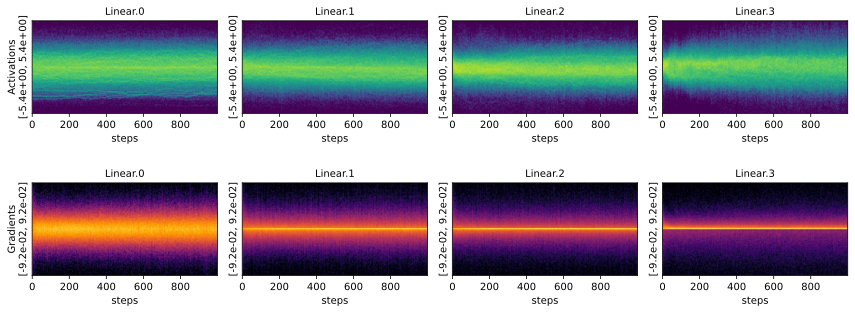

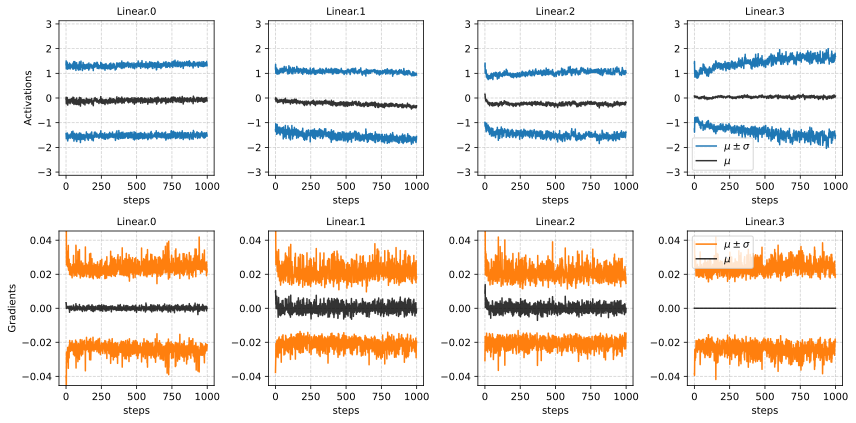

In [25]:
print("loss (last 100 steps):", sum(trainer.logs["train"]["loss"][-100:]) / 100)
plot_training_histograms([linear_outs_stats, linear_grad_stats], labels=["Activations", "Gradients"], cmaps=["viridis", "inferno"], figsize=(6, 1.2))
plot_training_stats([linear_outs_stats, linear_grad_stats], labels=["Activations", "Gradients"], figsize=(6, 1.5))

**Figure.** First row shows activation and gradient histograms over time. Ranges of values are 4$\times\sigma$ from the mean (over all time steps, units, layers). 
Considering each layer separately, the network is training well. 
Between layers we see that the gradient distribution changes. However, the second plot shows that the mean and standard deviation of the distributions remain approximately constant.

<br>

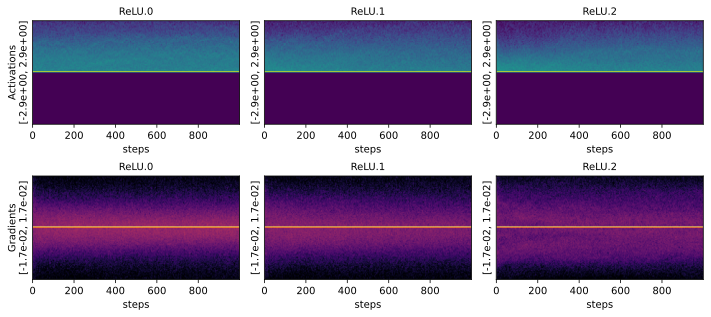

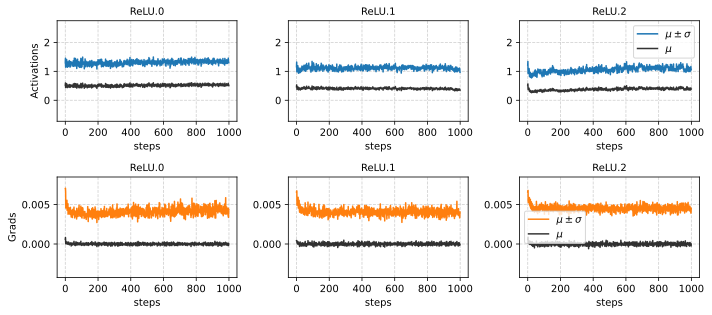

In [26]:
# can also check relu stats
plot_training_histograms([relu_outs_stats, relu_grad_stats], labels=["Activations", "Gradients"], cmaps=["viridis", "inferno"], figsize=(5.0, 1.5))
plot_training_stats([relu_outs_stats, relu_grad_stats], labels=["Activations", "Grads"], figsize=(5, 1.5), plot_neg_std=False)

<br>

**Example.** Trying out the experiment with the Pytorch default gain of $\frac{1}{\sqrt{3}}$. Notice that at early training steps, spread of activations decrease with depth. The network is able to recover later.

  0%|          | 0/1000 [00:00<?, ?it/s]

loss (last 100 steps): 2.5648341464996336


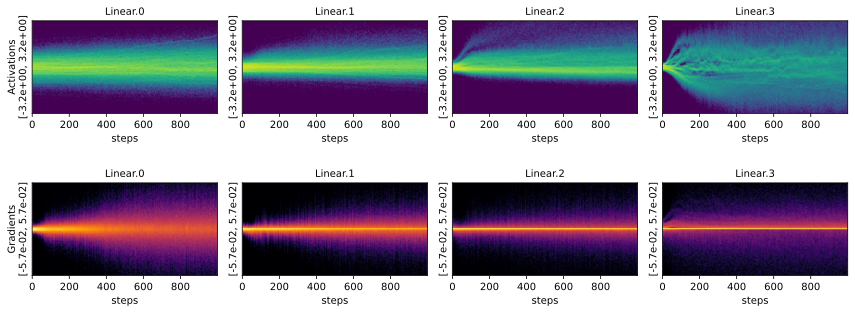

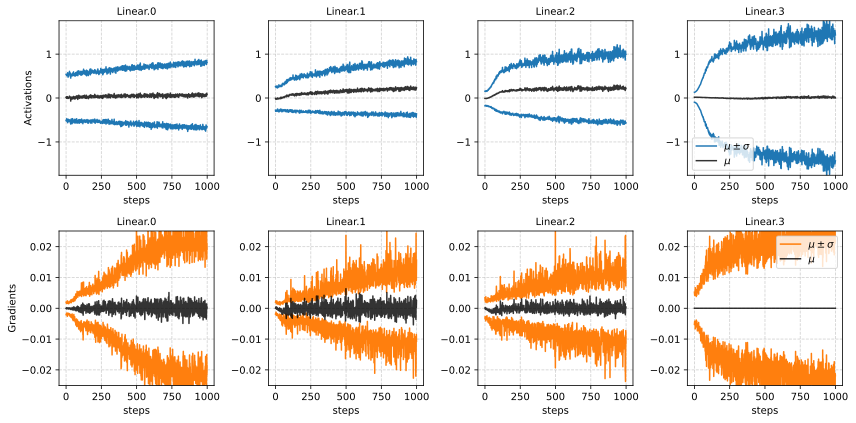

In [27]:
init_fn = lambda w: torch.nn.init.xavier_uniform_(w, gain=1.0 / math.sqrt(3.0))
model = init_model(get_model(**model_params), init_fn)
hooks = init_hooks()
trainer = run(model, train_dataset, **train_params, hooks=hooks)

print("loss (last 100 steps):", sum(trainer.logs["train"]["loss"][-100:]) / 100)
plot_training_histograms([linear_outs_stats, linear_grad_stats], labels=["Activations", "Gradients"], cmaps=["viridis", "inferno"], figsize=(6, 1.2))
plot_training_stats([linear_outs_stats, linear_grad_stats], labels=["Activations", "Gradients"], figsize=(6, 1.5))

<br>

**Example.** Initializing linear layers with $\sigma_{\boldsymbol{\mathsf{w}}} = 1$ demonstrates the importance of Xavier init:

  0%|          | 0/1000 [00:00<?, ?it/s]

loss (last 100 steps): 2.952916078567505


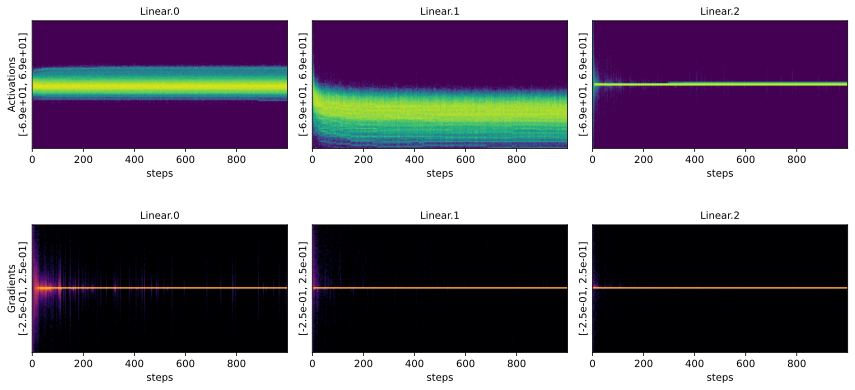

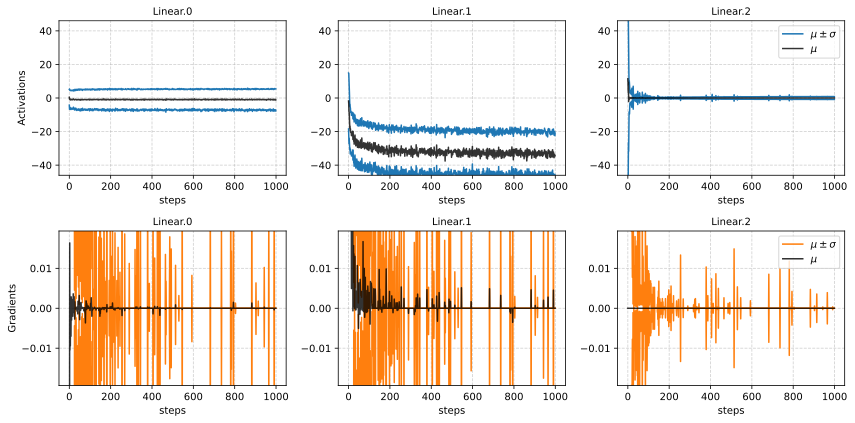

In [28]:
model_params["num_linear"] = 1                   #  Does not train any deeper
init_fn = lambda w: torch.nn.init.normal_(w)     #  w ~ N(0, 1)

model = init_model(get_model(**model_params), init_fn)
hooks = init_hooks()
trainer = run(model, train_dataset, **train_params, hooks=hooks)

print("loss (last 100 steps):", sum(trainer.logs["train"]["loss"][-100:]) / 100)
plot_training_histograms([linear_outs_stats, linear_grad_stats], labels=["Activations", "Gradients"], cmaps=["viridis", "inferno"])
plot_training_stats([linear_outs_stats, linear_grad_stats], labels=["Activations", "Gradients"], figsize=(6, 2))

### Dying units

Recall that ReLU units can die during training. Plotting this:

In [29]:
def plot_dying_relus(trainer, stats):
    module_list = [m for m in trainer.model.modules() if isinstance(m, nn.ReLU)]
    plt.figure(figsize=(6, 3))
    for i, m in enumerate(module_list):
        if isinstance(m, nn.ReLU):
            moving_avg = []
            steps = len(stats.records[m])
            w = int(0.05 * steps)
            for s in range(steps):
                moving_avg.append(np.mean(stats.records[m][-w + s + 1: s + 1]))

            plt.plot(moving_avg, label=f"ReLU.{i}")
        
    plt.legend()
    plt.grid(linestyle="dashed", alpha=0.6)
    plt.title(f"sat_threshold={stats.sat_threshold:.1e}, frac_treshold={stats.frac_threshold:.2f}", size=10)
    plt.xlabel("step")
    plt.ylabel("frac dead relu (MA)")
    plt.ylim(-0.1, 1.1)

  0%|          | 0/1000 [00:00<?, ?it/s]

loss (last 100 steps): 2.5302972650527953


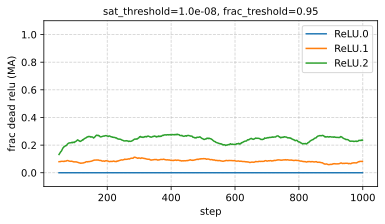

In [30]:
model_params["num_linear"] = 2  # default setup
init_fn = lambda w: torch.nn.init.xavier_uniform_(w, gain=np.sqrt(2)) 
hooks = init_hooks()
model = init_model(get_model(**model_params), init_fn)
trainer = run(model, train_dataset, **train_params, hooks=hooks)

print("loss (last 100 steps):", sum(trainer.logs["train"]["loss"][-100:]) / 100)
plot_dying_relus(trainer, dead_relu_stats)

<br>

Increasing LR from `0.1` to `2.0`. 
As discussed above, this can push weights to large values where the activations saturate,
knocking off the model to a flat region where any sample 
of the data does not affect the shape of the loss surface. Hence, the model barely trains with further SGD steps.

  0%|          | 0/1000 [00:00<?, ?it/s]

loss (last 100 steps): 2.816454916000366


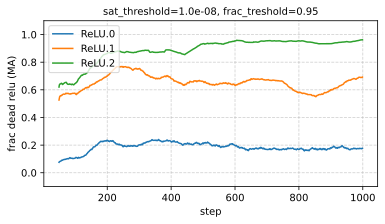

In [31]:
train_params["lr"] = 2.0
init_fn = lambda w: torch.nn.init.xavier_uniform_(w, gain=np.sqrt(2))
hooks = init_hooks()
model = init_model(get_model(**model_params), init_fn)
trainer = run(model, train_dataset, **train_params, hooks=hooks)

print("loss (last 100 steps):", sum(trainer.logs["train"]["loss"][-100:]) / 100)
plot_dying_relus(trainer, dead_relu_stats)

<br>

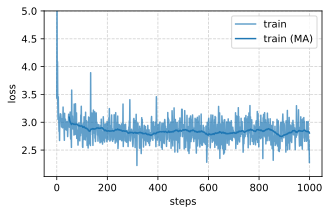

In [32]:
plot_training_loss(trainer)

loss (last 100 steps): 2.816454916000366


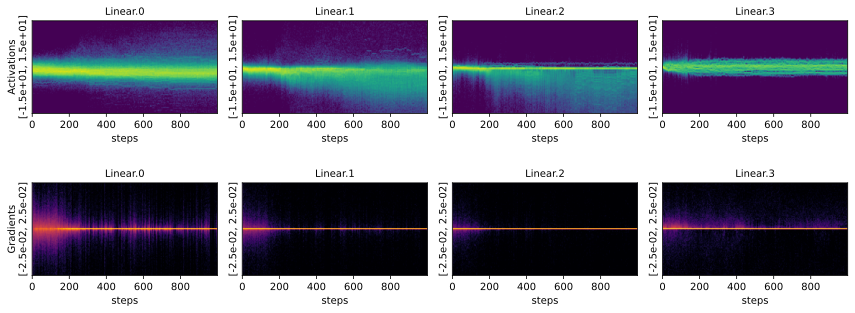

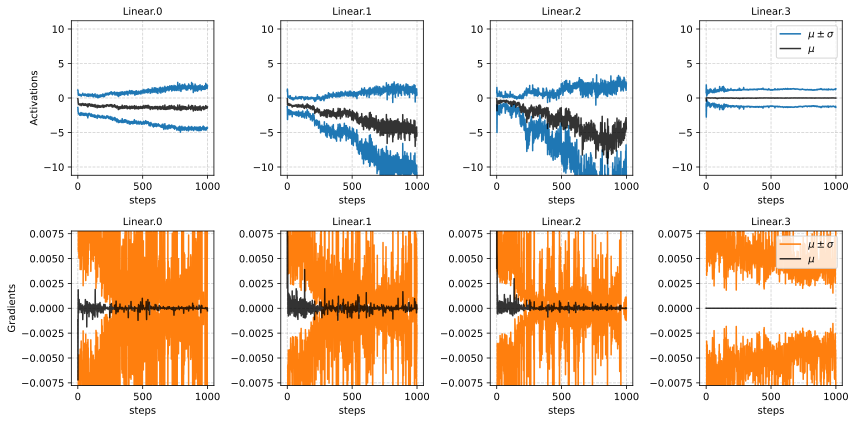

In [33]:
print("loss (last 100 steps):", sum(trainer.logs["train"]["loss"][-100:]) / 100)
plot_training_histograms([linear_outs_stats, linear_grad_stats], labels=["Activations", "Gradients"], cmaps=["viridis", "inferno"], figsize=(6, 1.2))
plot_training_stats([linear_outs_stats, linear_grad_stats], labels=["Activations", "Gradients"], figsize=(6, 1.5))

## Residual connections

  0%|          | 0/1000 [00:00<?, ?it/s]

loss (last 100 steps): 2.5870816016197207


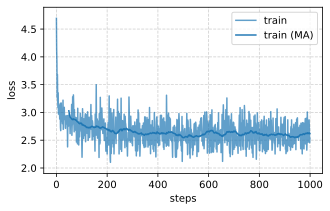

In [35]:
model_params["num_linear"] = 0
init_fn = lambda w: torch.nn.init.xavier_uniform_(w, gain=np.sqrt(2))
hooks = init_hooks()
model = init_model(get_model(**model_params), init_fn)
trainer = run(model, train_dataset, **train_params, hooks=hooks)

print("loss (last 100 steps):", sum(trainer.logs["train"]["loss"][-100:]) / 100)
plot_training_loss(trainer)

In [34]:
.

SyntaxError: invalid syntax (1933637684.py, line 1)

## Layer normalization

In [ ]:
.

---

■